##### A entropia está em nats ($e$)
Discreta

In [2]:
import numpy as np
from scipy.stats import entropy, rv_discrete
np.random.seed(1)

values = [1, 2, 3]
probabilities = [0.2, 0.3, 0.5]

dist = rv_discrete(values=(values, probabilities))
data = np.array(dist.rvs(size = 1000))

estimated_probabilities = [np.sum(data == i)/np.size(data) for i in set(data) ]

# counts, bins = np.histogram(data, bins=3, density=False)
# pmf = counts / len(data)
#* Não sei como ajustar automaticamente a saída do bins pro plot
 
print('PMF estimada: ', estimated_probabilities)
print('PMF real:     ', probabilities)

print('Entropia estimada: ', entropy(estimated_probabilities))
print('Entropia real:     ', entropy(probabilities))

print('Distância KL-1: ', entropy(estimated_probabilities, probabilities))
print('Distância KL-2: ', entropy(probabilities, estimated_probabilities))  

PMF estimada:  [0.203, 0.291, 0.506]
PMF real:      [0.2, 0.3, 0.5]
Entropia estimada:  1.0276098398302924
Entropia real:      1.0296530140645737
Distância KL-1:  0.0001946158160097168
Distância KL-2:  0.0001957543140255454


Contínua - Histograma


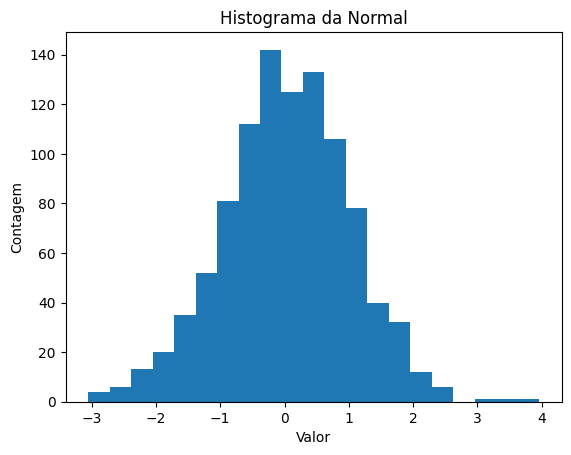

P(x > 0):  0.627
Entropia estimada:  2.43755888895662


In [3]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1)

data = np.random.normal(size=(1000))

counts, bins = np.histogram(data, bins=20, density=False)
idx = np.where((bins > 0))[0]
probability = np.sum(counts[idx - 1])/data.size

plt.hist(data, bins.size)
plt.xlabel('Valor')
plt.ylabel('Contagem')
plt.title('Histograma da Normal')
plt.show()

print('P(x > 0): ', probability)

print('Entropia estimada: ', entropy(counts/data.size))


Contínua - KDE


Entropia estimada:  1.416449063083199
Entropia real:      1.4189385332046727


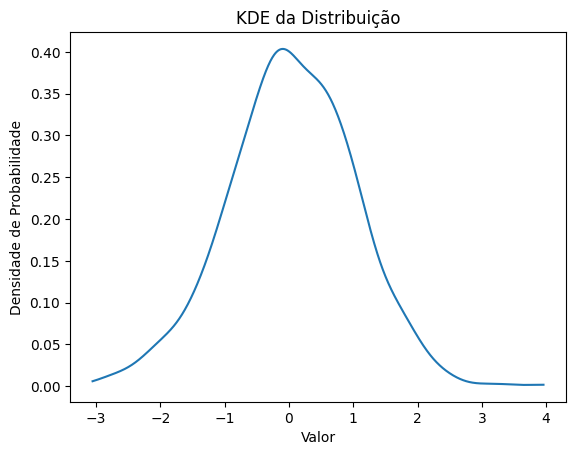

In [4]:
from scipy.stats import gaussian_kde
np.random.seed(1)

data = np.random.normal(size=(1000))

kde = gaussian_kde(data)
x_grid = np.linspace(data.min(), data.max(), 1000)

density = kde(x_grid)

epsilon = 1e-12
entropia = -np.trapz(density * np.log(density + epsilon), x_grid)

print('Entropia estimada: ',entropia)
print('Entropia real:     ', 0.5*(np.log(2*np.pi) + 1))

plt.plot(x_grid, density)
plt.xlabel('Valor')
plt.ylabel('Densidade de Probabilidade')
plt.title('KDE da Distribuição')
plt.show()

Testes sobre informação mútua

In [146]:
from sklearn.metrics import mutual_info_score
from npeet import entropy_estimators as ee
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

torch.manual_seed(0)
data = torch.randn(1000, 4)
targets = torch.zeros(1000, 2)
targets[data[:,0] > 2, 1] = 1 
targets[data[:,0] <= 2, 0] = 1

class PolicyNet(nn.Module):
    def __init__(self):
        super(PolicyNet, self).__init__()
        self.fc1 = nn.Linear(4, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 2) 

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

    
model = PolicyNet()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


# Número de épocas
num_epochs = 100
mutual_info = [[] for _ in range(9)]
for epoch in range(num_epochs):
    outputs = model(data)
    loss = criterion(outputs, targets)  
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        input_layer = data
        layer1_activations = torch.tanh(model.fc1(input_layer))
        layer2_activations = torch.tanh(model.fc2(layer1_activations))
        layer3_activations = model.fc3(layer2_activations)
        output_layer = model(data)
        
        mutual_info[0].append(ee.mi(input_layer, layer1_activations))
        mutual_info[1].append(ee.mi(input_layer, layer2_activations))
        mutual_info[2].append(ee.mi(input_layer, layer3_activations))
        mutual_info[3].append(ee.mi(input_layer, output_layer))

        mutual_info[4].append(ee.mi(layer1_activations, layer2_activations))
        mutual_info[5].append(ee.mi(layer1_activations, layer3_activations))
        mutual_info[6].append(ee.mi(layer1_activations, output_layer))
    
        mutual_info[7].append(ee.mi(layer2_activations, layer3_activations))
        mutual_info[8].append(ee.mi(layer2_activations, output_layer))
mutual_info = np.array(mutual_info)

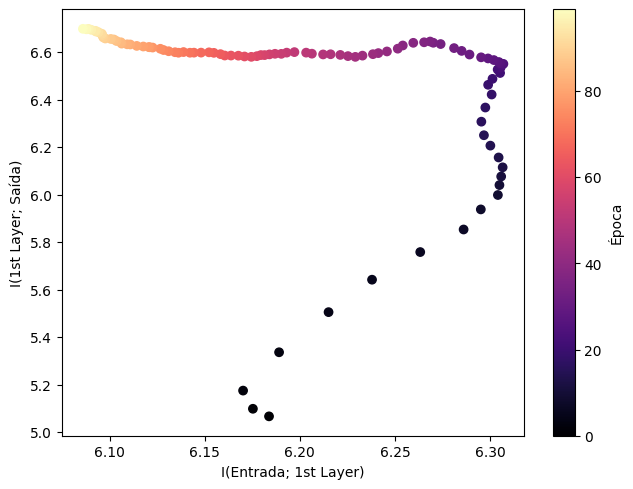

In [150]:
plt.scatter(mutual_info[0], mutual_info[4], c= np.arange(0, num_epochs), cmap= 'magma')
plt.tight_layout()
plt.xlabel('I(Entrada; 1st Layer)')
plt.ylabel('I(1st Layer; Saída)')
plt.colorbar(label='Época')
plt.show()

In [ ]:
import numpy as np
mutual_info = []
for peso1 in np.linspace(0,10, 1000):
    y = torch.tanh(data*peso1)
    bins = torch.linspace(-1, 1, 30)
    indices = torch.bucketize(y, bins)
    mutual_info.append(ee.mi(data,indices))

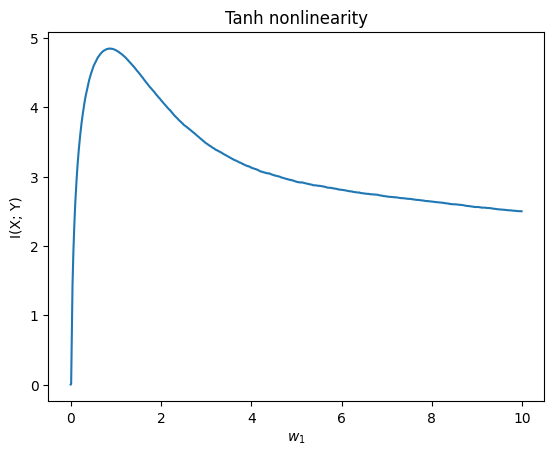

In [ ]:
plt.plot(np.arange(0,10, 1/100), mutual_info)
plt.title('Tanh nonlinearity')
plt.xlabel(r'$w_1$')
plt.ylabel('I(X; Y)')
plt.show()